In [10]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import shutil

# Function to preprocess and resize images
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for image_path in images:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, target_size)  # Resize image to target size
        processed_images.append(img)
    return np.array(processed_images)

# Folder path containing images
folder_path = 'arr_img'

# Output folder path
output_folder = 'sorted_images_3'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Preprocess images and extract image paths
images = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith(".jpg")]

# Preprocess and resize images for VGG16 model
X = preprocess_images(images)

# Load pre-trained VGG16 model (without fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define a model that extracts features from a specific layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv3').output)

# Extract features using the specific layer model
features = model.predict(preprocess_input(X))

# Reshape features for clustering
features_flat = features.reshape(features.shape[0], -1)

# Cluster images based on CNN features
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features_flat)

# Get cluster labels
cluster_labels = kmeans.labels_

# Sort images into different folders based on clusters
for cluster_id in range(4):
    cluster_folder = os.path.join(output_folder, f'cluster_{cluster_id}')
    if not os.path.exists(cluster_folder):
        os.makedirs(cluster_folder)
    cluster_images = [images[i] for i, label in enumerate(cluster_labels) if label == cluster_id]
    for img_path in cluster_images:
        img_name = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(cluster_folder, img_name))


6/6 [==============================] - 13s 2s/step


Silhouette Score: 0.08565911


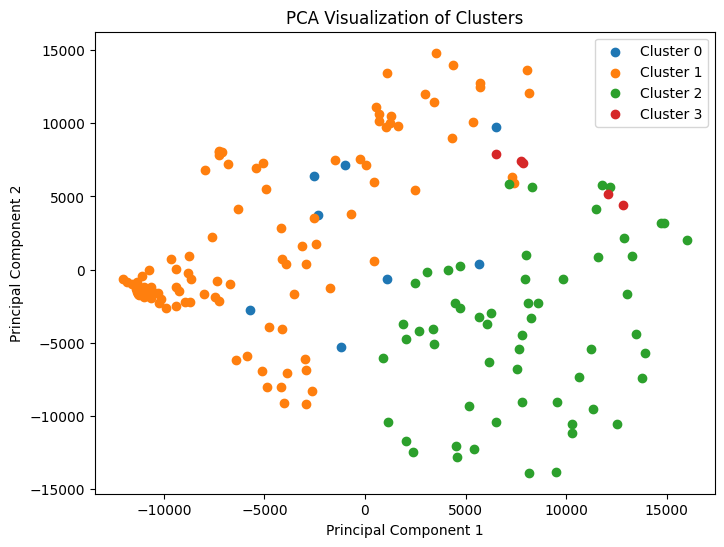

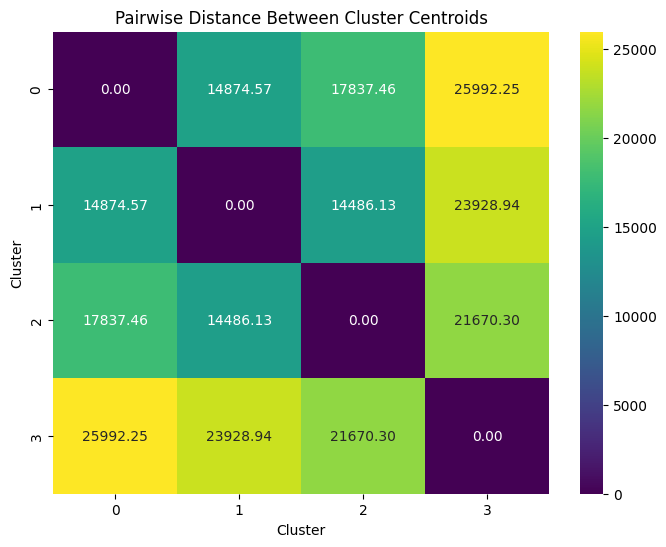

In [11]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances

# Cluster images based on CNN features
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features_flat)

# Get cluster labels
cluster_labels = kmeans.labels_

# Compute silhouette score
silhouette_avg = silhouette_score(features_flat, cluster_labels)
print("Silhouette Score:", silhouette_avg)

# Perform PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_flat)

# Plot PCA visualization
plt.figure(figsize=(8, 6))
for cluster_id in range(4):
    cluster_indices = np.where(cluster_labels == cluster_id)
    plt.scatter(pca_features[cluster_indices, 0], pca_features[cluster_indices, 1], label=f'Cluster {cluster_id}')
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Compute pairwise distances between cluster centroids
centroid_distances = pairwise_distances(kmeans.cluster_centers_)

# Plot pairwise heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(centroid_distances, annot=True, cmap='viridis', fmt=".2f")
plt.title('Pairwise Distance Between Cluster Centroids')
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.show()